# Import Liberaries

In [1]:
!which python

/home/mahdi/miniconda3/bin/python


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd

sys.path.append('/home/mahdi/WaterBalance/')

In [3]:
import ee
import wxee

ee.Authenticate()
wxee.Initialize()


Successfully saved authorization token.


# Varables

In [4]:
PATH_DATA = "/mnt/e/Term2/payan_name/import/DataQDWB/"

# mashhad
# LAT_MIN = 35.80
# LAT_MAX = 37.11
# LON_MIN = 58.31
# LON_MAX = 60.14

# USA
LAT_MIN = 43.30
LAT_MAX = 44.60
LON_MIN = -109.40
LON_MAX = -107.40


# Functions

In [5]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

# Load Data

In [6]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)

mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file('/mnt/e/Term2/payan_name/import/sample/usa.shp')


In [7]:
import geemap

Map = geemap.Map()
Map.add_basemap('HYBRID')


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')


CN_Wyoming = CN_Wyoming.clip(shape)
 
Map.centerObject(shape, 9)
Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
Map

Map(center=[43.95199004841242, -108.40000000000003], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs='EPSG:4326')
arr

Downloading:   0%|          | 0.00/64.1k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, x: 892, y: 582)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 44.6 44.6 44.6 44.6 44.6 ... 43.31 43.31 43.3 43.3 43.3
  * x        (x) float64 -109.4 -109.4 -109.4 -109.4 ... -107.4 -107.4 -107.4
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... 59.0 59.0 59.0 59.0

## reroject CN array accoring to precipitation array

In [12]:
da = arr.rio.write_crs("epsg:4326", inplace=True)

P.rio.write_crs("epsg:4326", inplace=True)

p = P.rename({'lon': 'x','lat': 'y'})

xds_repr_match = da.rio.reproject_match(p)
xds_repr_match


<xarray.Dataset>
Dimensions:      (time: 1, x: 20, y: 13)
Coordinates:
  * x            (x) float32 -109.3 -109.2 -109.1 ... -107.6 -107.5 -107.4
  * y            (y) float32 44.55 44.45 44.35 44.25 ... 43.65 43.55 43.45 43.35
  * time         (time) datetime64[ns] 2015-01-01
    spatial_ref  int64 0
Data variables:
    dry          (time, y, x) float64 53.0 53.0 55.0 57.0 ... 64.0 64.0 64.0

## plot reprojected CN array

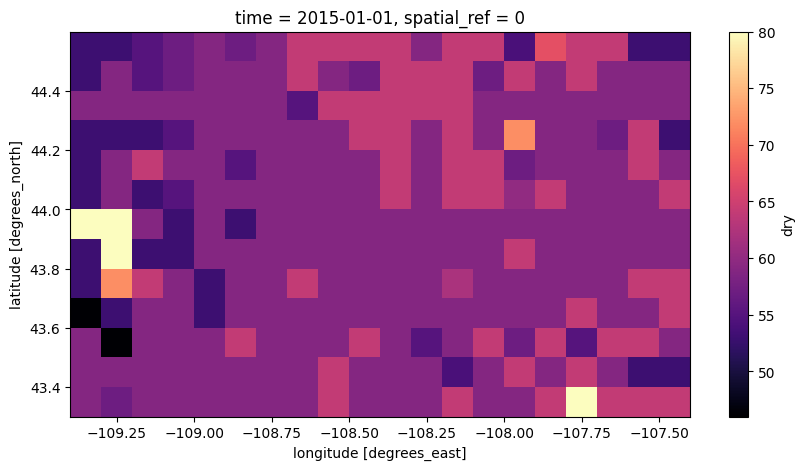

In [13]:
xds_repr_match.dry.plot(figsize=(10, 5), cmap="magma")

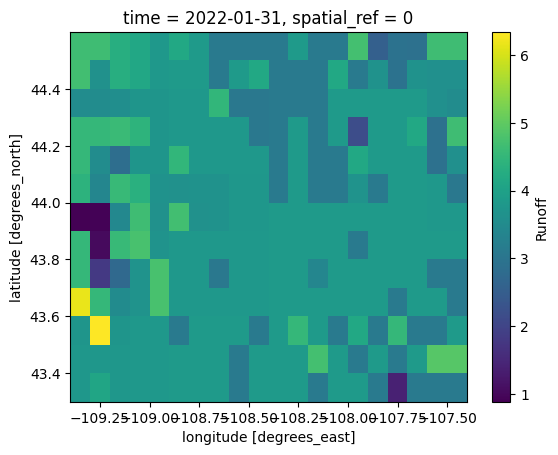

In [14]:
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *

cn =list(xds_repr_match.dry.values.flatten())
pre =list(p.precipitation.values.flatten())

R = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[0]
for i, j in zip(pre,cn)])

underground_runoff = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[1]
for i, j in zip(pre,cn)])

R_array = R.reshape(1,13,20)
underground_runoff_array = underground_runoff.reshape(1,13,20)


ds_array = p.assign(Runoff=(['time', 'y', 'x'], R_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_1.Runoff.plot()
